In [2]:
#!pip install geopandas

### Imports

In [3]:
import pandas as pd
from shapely import wkt
import geopandas

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
from sklearn.model_selection import train_test_split

### Leemos la data con todas la variables:

In [5]:
data = pd.read_csv('../Datasets/merged_socialdata_placesinfo_starbucksdata.csv')

Transformamos este DataFrame a un GeoDataFrame para evitar futuros problemas con las geometrías:

In [6]:
data['geometry'] = data['geometry'].apply(wkt.loads)
data = geopandas.GeoDataFrame(data)

En la lista *main_columns* se van a guardar las variables que consideramos relevantes para incluir en el modelo conforme vamos haciendo el análisis:

In [7]:
main_columns = ['revenue','storenumber','Geographic Area Name']

### Dividimos en train/test

Mantenemos la misma división que en el main, para no cometer data leakage

In [8]:
stores_for_train = np.load('../Datasets/storenumbers_splitted/stores_for_train.npy')
train = data[data['storenumber'].isin(stores_for_train)]

In [9]:
data = train.copy()
data.shape

(132, 157)

### Visualización de la distribución de la variable objetivo:

Antes que nada, para tener una idea de la variable que pretendemos predecir más adelante en el modelo, vamos a ver su distribución y en qué rangos se mueve:

<AxesSubplot:xlabel='revenue', ylabel='Density'>

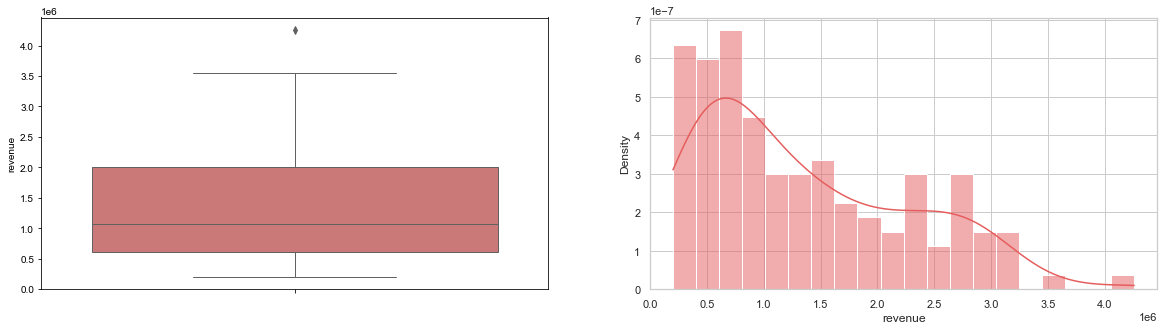

In [10]:
plt.subplots(nrows=1,ncols=2,figsize=(20,5))

plt.subplot(1,2,1)
sns.set_theme(style="whitegrid")
sns.boxplot(data=data, y='revenue', saturation = 0.6, linewidth = 1, color = '#E55D5D')
plt.subplot(1,2,2)
sns.set_theme(style="whitegrid")
sns.histplot(data['revenue'],color = '#E55D5D', bins = 20,kde = True, stat='density')

Vemos que en el boxplot se consideran outliers aquellas instancias con un valor de "revenue" por encima de 4000000 <br> Esto se corresponde a la perfección con lo que se observa en la distribución del gráfico de la derecha, ya que vemos que hay muy poca cantidad de tiendas con un valor tan alto no es significativo. Es por eso, que para hacer el modelo más robusto eliminamos todas las tiendas que tienen más de este valor de revenue anual:

In [11]:
# Eliminamos los outliers en revenue:
data = data[data["revenue"] <= 4000000]

### Análisis de campos nulos:

In [12]:
counter = 0
for variable in data.columns:
    num_nulls = data[variable].isnull().sum()
    if num_nulls > 0:
        print(f"{variable}: \t {num_nulls} nulls")
        counter = counter + 1
        
if counter == 0:
    print("No missing values in any column!")

No missing values in any column!


Vemos que no hay valores nulos, por lo que no será un tema a tratar en este análisis.

### Data types:

In [13]:
variables_types = []

for variable in set(data.columns) - set(main_columns):
    variable_type = data[variable].dtype
    if variable_type not in variables_types:
        variables_types.append(variable_type)
    if variable_type == 'O':
        print(variable)
print(variables_types)

Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)
Estimate!!SEX AND AGE!!Total population!!Median age (years)
Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females)
Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)
[dtype('int64'), dtype('O'), <geopandas.array.GeometryDtype object at 0x7ffd1a505710>]


Vemos que de las variables que tenemos que analizar casi todas son tipo 'int' y hay 4 que son tipo 'object'. <br> Por lo que en general no habrá que hacer categorización ni encoding de las varibles y estos 4 casos de variables que no son tipo 'int' se estudiarán en el análisis de **var_sex_age_population**

### Clasificación de las variables
Debido a la gran cantidad de variables que se manejan en este estudio, las clasificamos por temática para poder hacer más sencillo y entendible el análisis.
<br> De este forma obtenemos 15 sets de variables que iremos analizando poco a pocoo:

In [14]:
var_non_family = set(data.columns[data.columns.str.contains('NONFAMILY')])

var_num_families = set(data.columns[data.columns.str.contains('Number!!FAMILIES!!')])

var_income_by_race = set(data.columns[data.columns.str.contains('INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER')])

var_population_by_race = set(data.columns[data.columns.str.contains('HISPANIC OR LATINO AND RACE!!Total population')])

var_race_population = set(data.columns[((data.columns.str.contains('RACE!!Total population')) | (data.columns.str.contains('Race alone or in combination with one or more other races!!Total population')))])  - set(var_population_by_race)

var_family_income = set(data.columns[(data.columns.str.contains('FAMILY INCOME BY FAMILY SIZE!!')) | data.columns.str.contains('FAMILY INCOME BY NUMBER OF EARNERS!!')])

var_sex_age_population = set(data.columns[data.columns.str.contains('SEX AND AGE!!Total population')])

var_household_income_by_age = set(data.columns[data.columns.str.contains('HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!')])

var_pop_over18 = set(data.columns[data.columns.str.contains('CITIZEN, VOTING AGE POPULATION!!')])

var_total_housing_units = set(data.columns[data.columns.str.contains('Estimate!!Total housing units')])

var_income_by_race = set(data.columns[data.columns.str.contains('INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER')])

var_family_income = set(data.columns[(data.columns.str.contains('FAMILY INCOME BY FAMILY SIZE!!')) | data.columns.str.contains('FAMILY INCOME BY NUMBER OF EARNERS!!')])

var_sex_age_population = set(data.columns[data.columns.str.contains('SEX AND AGE!!Total population')])

var_household_income_by_age = set(data.columns[data.columns.str.contains('HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!')])

var_total_housing_units = set(data.columns[data.columns.str.contains('Estimate!!Total housing units')])

Ahora procedemos a analizar las variables por los distintos sets que hemos montado.
<br> Para cada uno de estos sets nos centraremos en las **correlaciones** que tienen las variables entre sí (se espera una alta correlación ya que son variables que entre sí se repiten y que tratan el mismo tema). <br> No se harán otras técnicas de limpieza ni otros análisis ya que como hemos visto tenemos un dataset numérico y sin nulos. 

### Analizamos las variables en "var_non_family"

In [15]:
var_non_family.update(['revenue'])
print('Las variables en **var_non_family** son: ')
data[var_non_family].columns.to_list()

Las variables en **var_non_family** son: 


['Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Living alone',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Not living alone',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Not living alone',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households',
 'revenue',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Living alone']

In [16]:
# Compute the correlation matrix
corr = np.abs(data[var_non_family].drop(['revenue'], axis=1).corr())

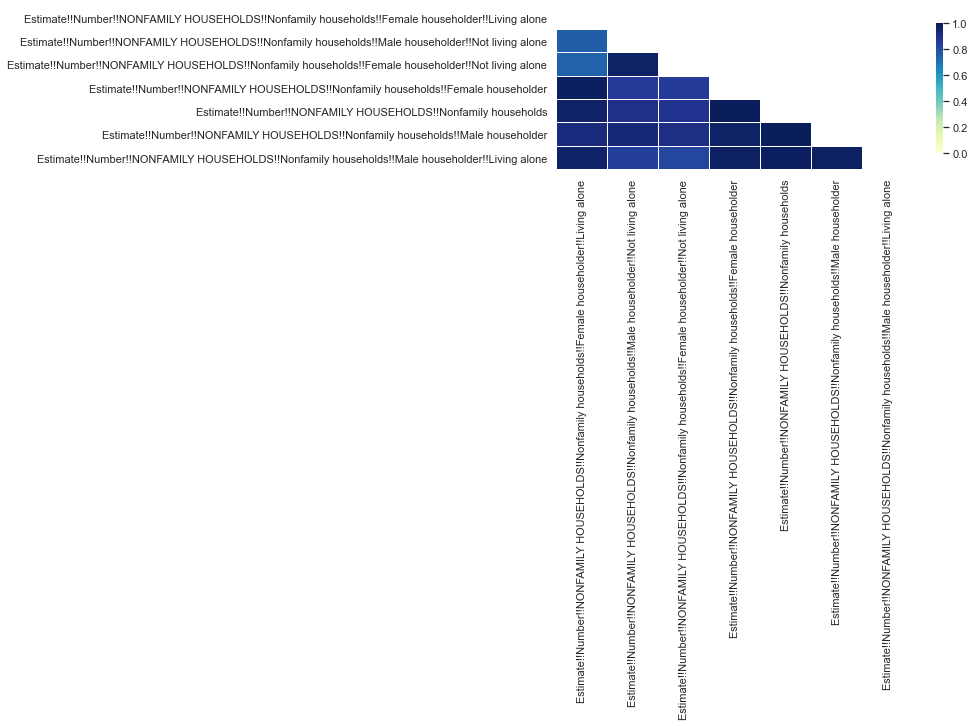

In [17]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 3))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Podemos ver que entre todas estas variables hay una alta correlación (lo cual es esperable). 
<br> Vamos a ver cuales explican mejor el "revenue" de las tiendas mediante la correlación con la variable objetivo.

In [18]:
aux = pd.DataFrame()
for variable in (var_non_family):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Living alone
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Living alone
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Not living alone
Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Not living alone


abs_correlation_with_revenue  correlation_with_revenue  \
1                      0.611573                 -0.611573   
2                      0.600581                 -0.600581   
3                      0.596924                 -0.596924   
4                      0.595128                 -0.595128   
5                      0.588326                 -0.588326   
6                      0.487075                 -0.487075   
7                      0.461259                 -0.461259   

                                            variable  
1  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
2  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
3  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
4  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
5  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
6  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...  
7  Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfam...

Nos quedamos con:
- Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Living alone
- Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Living alone

In [19]:
main_columns.append('Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Living alone')
main_columns.append('Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Living alone')

### Analizamos las variables en "var_num_families"

In [20]:
var_num_families.update(['revenue'])
print('Las variables en **var_num_families** son: ')
data[var_num_families].columns.to_list()

Las variables en **var_num_families** son: 


['Estimate!!Number!!FAMILIES!!Families!!Male householder, no spouse present!!With own children under 18 years',
 'Estimate!!Number!!FAMILIES!!Families!!Married-couple families',
 'Estimate!!Number!!FAMILIES!!Families!!Married-couple families!!With own children under 18 years',
 'Estimate!!Number!!FAMILIES!!Families',
 'Estimate!!Number!!FAMILIES!!Families!!Female householder, no spouse present',
 'revenue',
 'Estimate!!Number!!FAMILIES!!Families!!With own children of householder under 18 years',
 'Estimate!!Number!!FAMILIES!!Families!!Male householder, no spouse present',
 'Estimate!!Number!!FAMILIES!!Families!!With no own children of householder under 18 years',
 'Estimate!!Number!!FAMILIES!!Families!!Female householder, no spouse present!!With own children under 18 years']

In [21]:
# Compute the correlation matrix
corr = np.abs(data[var_num_families].drop(['revenue'], axis=1).corr())

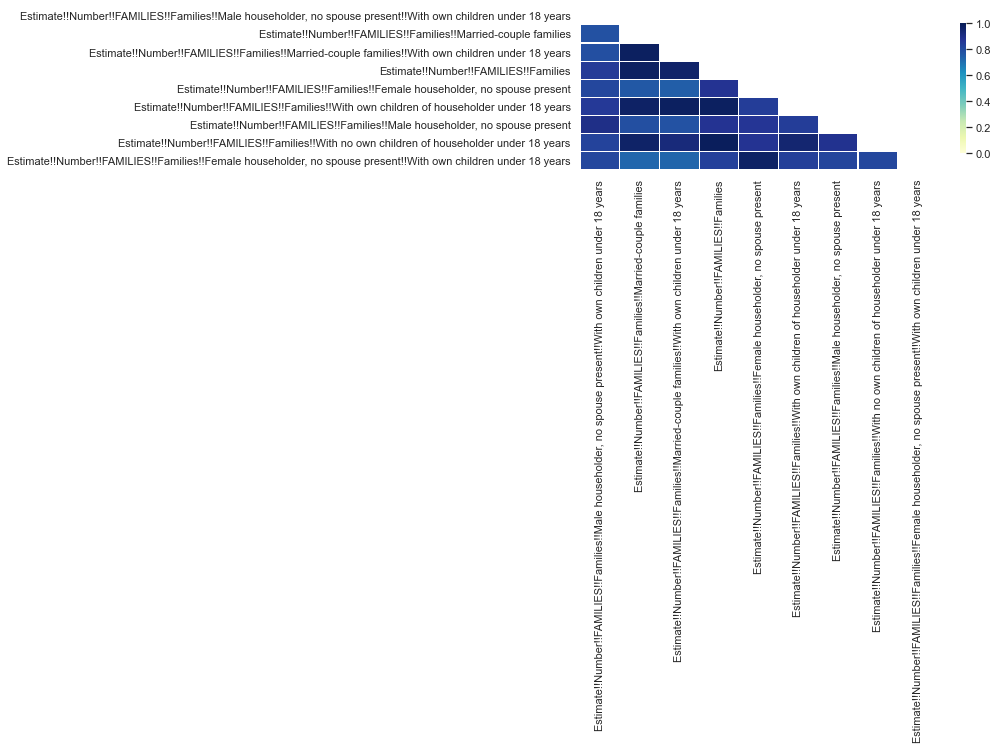

In [22]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 3))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [23]:
aux = pd.DataFrame()
for variable in (var_num_families):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Number!!FAMILIES!!Families!!Female householder, no spouse present
Estimate!!Number!!FAMILIES!!Families!!With no own children of householder under 18 years
Estimate!!Number!!FAMILIES!!Families!!Female householder, no spouse present!!With own children under 18 years
Estimate!!Number!!FAMILIES!!Families!!Male householder, no spouse present!!With own children under 18 years
Estimate!!Number!!FAMILIES!!Families
Estimate!!Number!!FAMILIES!!Families!!Male householder, no spouse present
Estimate!!Number!!FAMILIES!!Families!!With own children of householder under 18 years
Estimate!!Number!!FAMILIES!!Families!!Married-couple families
Estimate!!Number!!FAMILIES!!Families!!Married-couple families!!With own children under 18 years


abs_correlation_with_revenue  correlation_with_revenue  \
1                      0.497655                 -0.497655   
2                      0.483738                 -0.483738   
3                      0.474763                 -0.474763   
4                      0.471205                 -0.471205   
5                      0.467083                 -0.467083   
6                      0.465893                 -0.465893   
7                      0.429534                 -0.429534   
8                      0.419886                 -0.419886   
9                      0.380469                 -0.380469   

                                            variable  
1  Estimate!!Number!!FAMILIES!!Families!!Female h...  
2  Estimate!!Number!!FAMILIES!!Families!!With no ...  
3  Estimate!!Number!!FAMILIES!!Families!!Female h...  
4  Estimate!!Number!!FAMILIES!!Families!!Male hou...  
5               Estimate!!Number!!FAMILIES!!Families  
6  Estimate!!Number!!FAMILIES!!Families!!Male hou...  
7  Estimate!!Number!!FAMILIES!!Families!!With own...  
8  Estimate!!Number!!FAMILIES!!Families!!Married-...  
9  Estimate!!Number!!FAMILIES!!Families!!Married-...

Vemos que además de estar entre ellas muy correlacionadas, no hay casi diferencia entre las primeras 6 variables en el DataFrame *aux* de correlación con la varible objetivo. 
<br> Por eso, vamos a mantener la que es un "add up" de todas las demás ya que contabiliza todas las familias sin entrar a distinguir por detalles:
* Estimate!!Number!!FAMILIES!!Families

In [24]:
main_columns.append('Estimate!!Number!!FAMILIES!!Families')

### Analizamos las variables en "var_population_by_race"

In [25]:
var_population_by_race.update(['revenue'])
print('Las variables en **var_population_by_race** son: ')

data[var_population_by_race].columns.to_list()

Las variables en **var_population_by_race** son: 


['Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!American Indian and Alaska Native alone',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Asian alone',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Some other race alone',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!White alone',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)!!Cuban',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more race

In [26]:
# Compute the correlation matrix
corr = np.abs(data[var_population_by_race].drop(['revenue'], axis=1).corr())

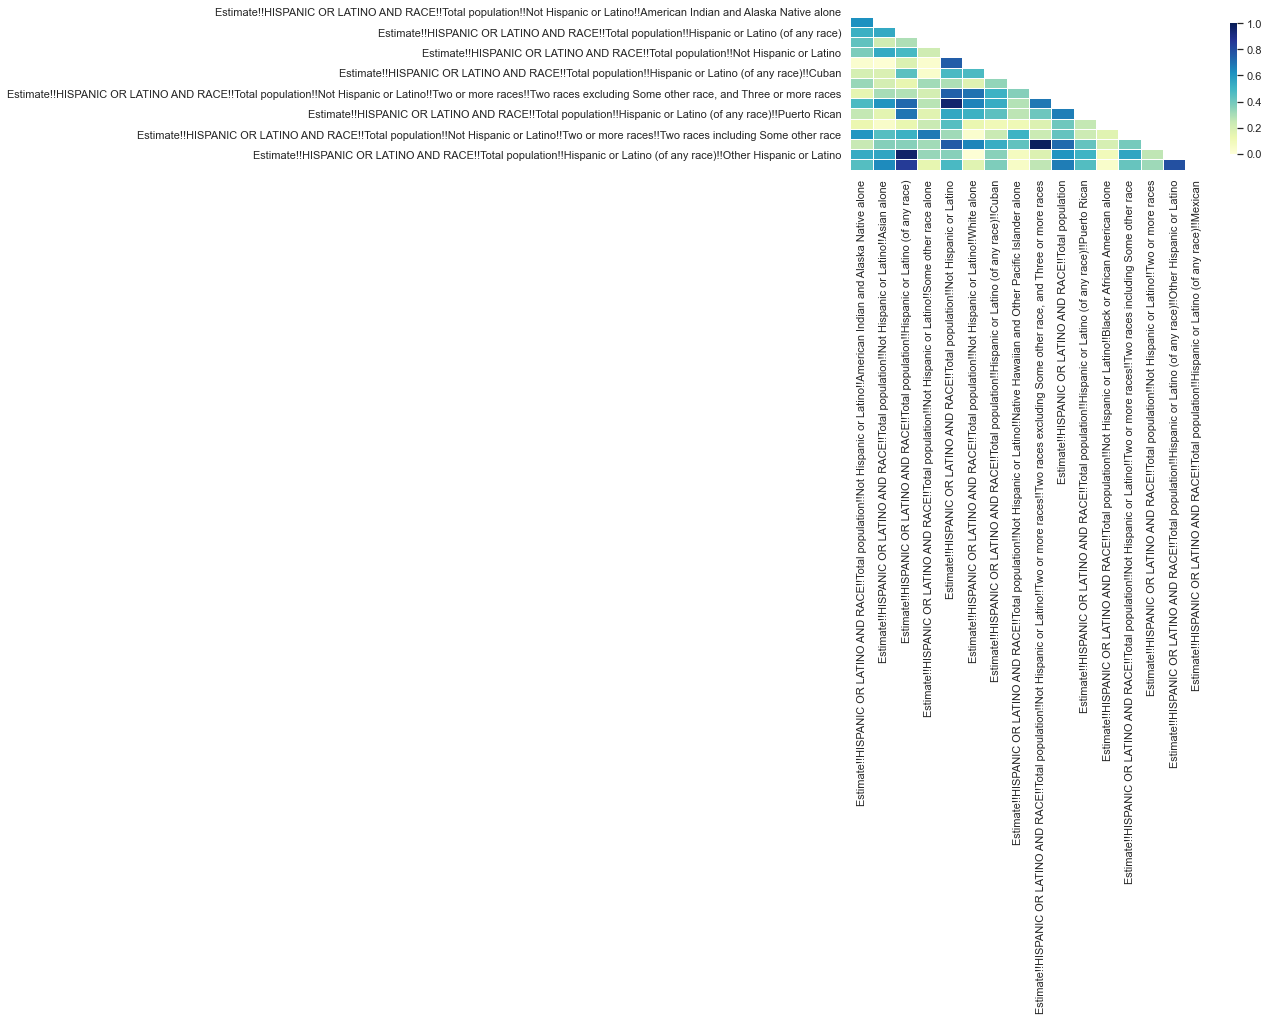

In [27]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 3))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

En este caso ya no hay tanto correlación, pero si que viendo las variables vemos un desglose al por menor innecesario. Por lo que vamos a ver como se comportan cada una de ellas con la variable objetivo, con la intención de quedarnos (como en los casos anteriores) con una o dos que sean resumen o más representativas. 

In [28]:
aux = pd.DataFrame()
for variable in (var_population_by_race):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!HISPANIC OR LATINO AND RACE!!Total population
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or more races
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or more races!!Two races excluding Some other race, and Three or more races
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Asian alone
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)!!Mexican
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)!!Other Hispanic or Latino
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)!!Cuban
Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)!!Puerto Rican
Estim

abs_correlation_with_revenue  correlation_with_revenue  \
1                       0.488216                 -0.488216   
2                       0.472109                 -0.472109   
3                       0.465854                 -0.465854   
4                       0.457462                 -0.457462   
5                       0.419286                 -0.419286   
6                       0.368584                 -0.368584   
7                       0.354581                 -0.354581   
8                       0.301838                 -0.301838   
9                       0.289292                 -0.289292   
10                      0.286651                 -0.286651   
11                      0.232706                 -0.232706   
12                      0.230719                 -0.230719   
13                      0.216279                 -0.216279   
14                      0.206287                 -0.206287   
15                      0.200804                 -0.200804   
16                      0.139687                 -0.139687   

                                             variable  
1   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
2   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
3   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
4   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
5   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
6   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
7   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
8   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
9   Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
10  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
11  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
12  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
13  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
14  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
15  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...  
16  Estimate!!HISPANIC OR LATINO AND RACE!!Total p...

Mantenemos:
- Estimate!!HISPANIC OR LATINO AND RACE!!Total population

Además de ser la que mejor explica la varible "revenue" es la más genérica, por lo que en temas de escalabilidad y generalización suponemos que funcionará mejor para el modelo. 

In [29]:
main_columns.append('Estimate!!HISPANIC OR LATINO AND RACE!!Total population')

### Analizamos las variables en "var_race_population"

In [30]:
var_race_population.update(['revenue'])

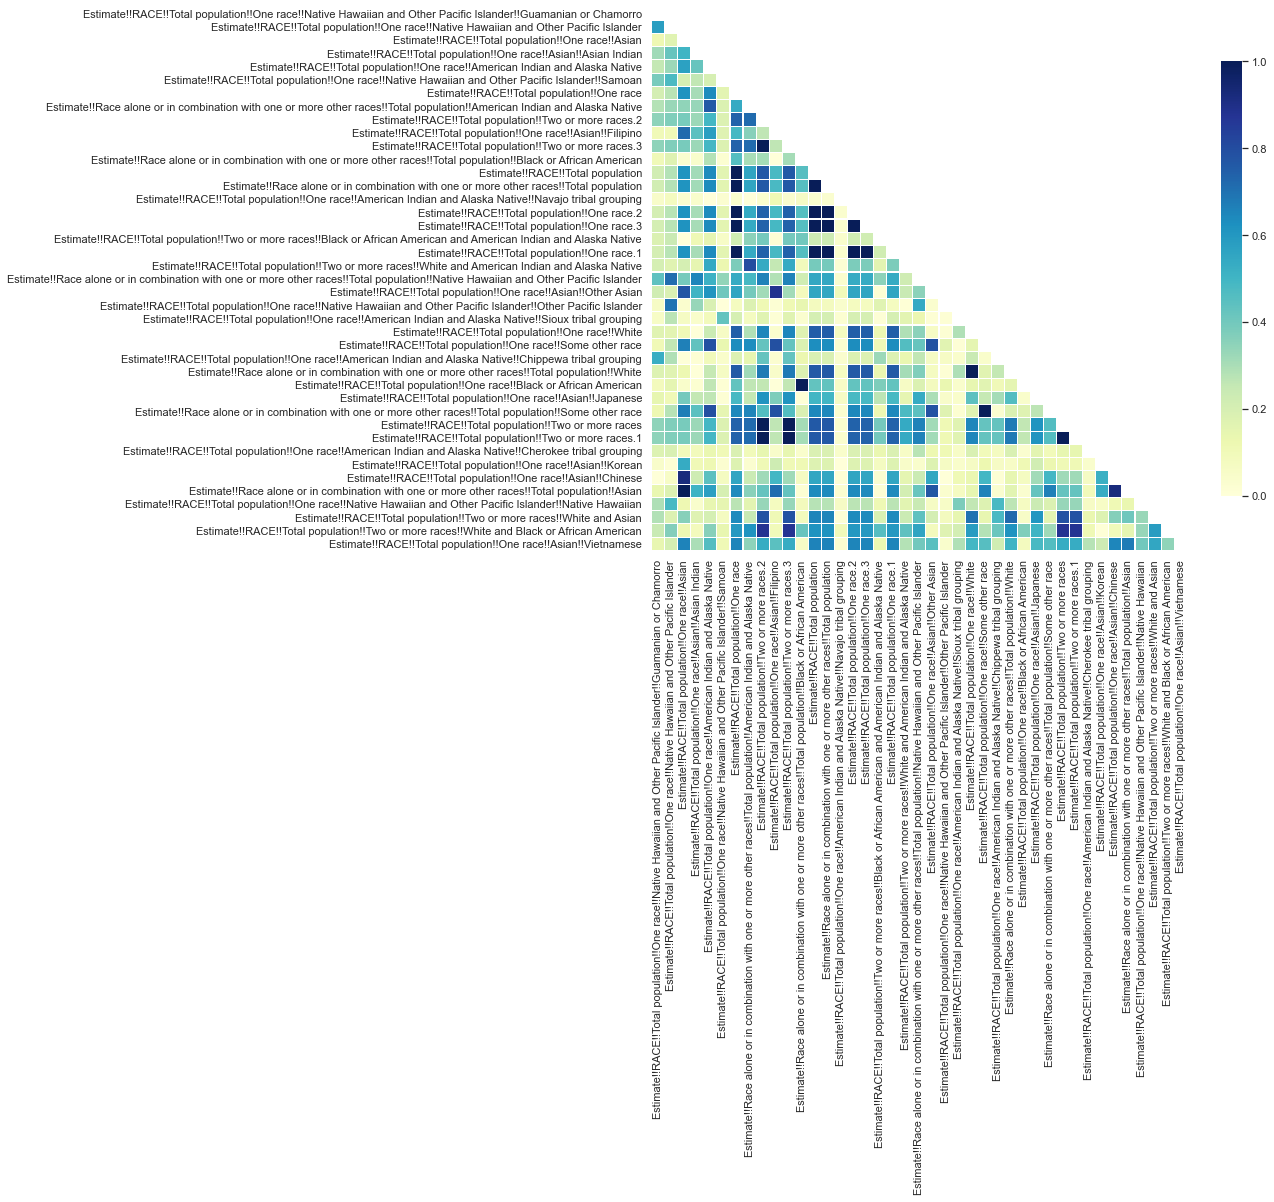

In [31]:
# Compute the correlation matrix
corr = np.abs(data[var_race_population].drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

En este caso, como en el anterior que hace referencia a las razas, vemos que las distinciones van muy al detalle y las consideramos innecesarias.
<br> Por eso hacemos una preselección de las más generels y vemos como interactúan con "revenue".
- Estimate!!RACE!!Total population!!One race!!White
- Estimate!!RACE!!Total population!!One race!!Asian
- Estimate!!RACE!!Total population!!One race!!Black or African American
<br><br> También incluimos:
<br> 
- Estimate!!RACE!!Total population!!Two or more races
- Estimate!!RACE!!Total population!!One race
<br><br> Ya que puede no importar qué razas hay sino la interracialidad o no en la zona.

In [32]:
selected_variables = ['Estimate!!RACE!!Total population!!One race!!White',\
                      'Estimate!!RACE!!Total population!!One race!!Asian',\
                      'Estimate!!RACE!!Total population!!One race!!Black or African American',\
                      'Estimate!!RACE!!Total population!!Two or more races',\
                      'Estimate!!RACE!!Total population!!One race']

In [33]:
aux = pd.DataFrame()
for variable in (selected_variables):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux

Estimate!!RACE!!Total population!!Two or more races
Estimate!!RACE!!Total population!!One race
Estimate!!RACE!!Total population!!One race!!Asian
Estimate!!RACE!!Total population!!One race!!White
Estimate!!RACE!!Total population!!One race!!Black or African American


abs_correlation_with_revenue  correlation_with_revenue  \
0                      0.506765                 -0.506765   
1                      0.481328                 -0.481328   
2                      0.419598                 -0.419598   
3                      0.262437                 -0.262437   
4                      0.226678                 -0.226678   

                                            variable  
0  Estimate!!RACE!!Total population!!Two or more ...  
1         Estimate!!RACE!!Total population!!One race  
2  Estimate!!RACE!!Total population!!One race!!Asian  
3  Estimate!!RACE!!Total population!!One race!!White  
4  Estimate!!RACE!!Total population!!One race!!Bl...

Vemos que la cantidad de raza "blanca" y raza "negra" no influye casi, mientras que las tres primeras si que explican el "revenue" de un local.

Mantenemos:
* Estimate!!RACE!!Total population!!One race!!Asian
* Estimate!!RACE!!Total population!!Two or more races
* Estimate!!RACE!!Total population!!One race

In [34]:
main_columns.append('Estimate!!RACE!!Total population!!One race!!Asian')
main_columns.append('Estimate!!RACE!!Total population!!Two or more races')
main_columns.append('Estimate!!RACE!!Total population!!One race')

### Analizamos las variables en "var_pop_over18" 

In [35]:
var_pop_over18.update(['revenue'])
print('Las variables en **var_pop_over18** son: ')
data[var_pop_over18].columns.to_list()

Las variables en **var_pop_over18** son: 


['revenue',
 'Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female',
 'Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population',
 'Estimate!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Male']

Estas variables las tenemos más adelante en "var_sex_age_population" y con más desglose por lo que estas no son informativas teniendo ya las otras y no nos quedaremos con ninguna para nuestro modelo.

### Analizamos las variables en "var_income_by_race"

In [36]:
var_income_by_race.update(['revenue'])
print('Las variables en **var_income_by_race** son: ')
data[var_income_by_race].columns.to_list()

Las variables en **var_income_by_race** son: 


['Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!White',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Two or more races',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!American Indian and Alaska Native',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!White alone, not Hispanic or Latino',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!Black or African American',
 'revenue',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!Asian',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HO

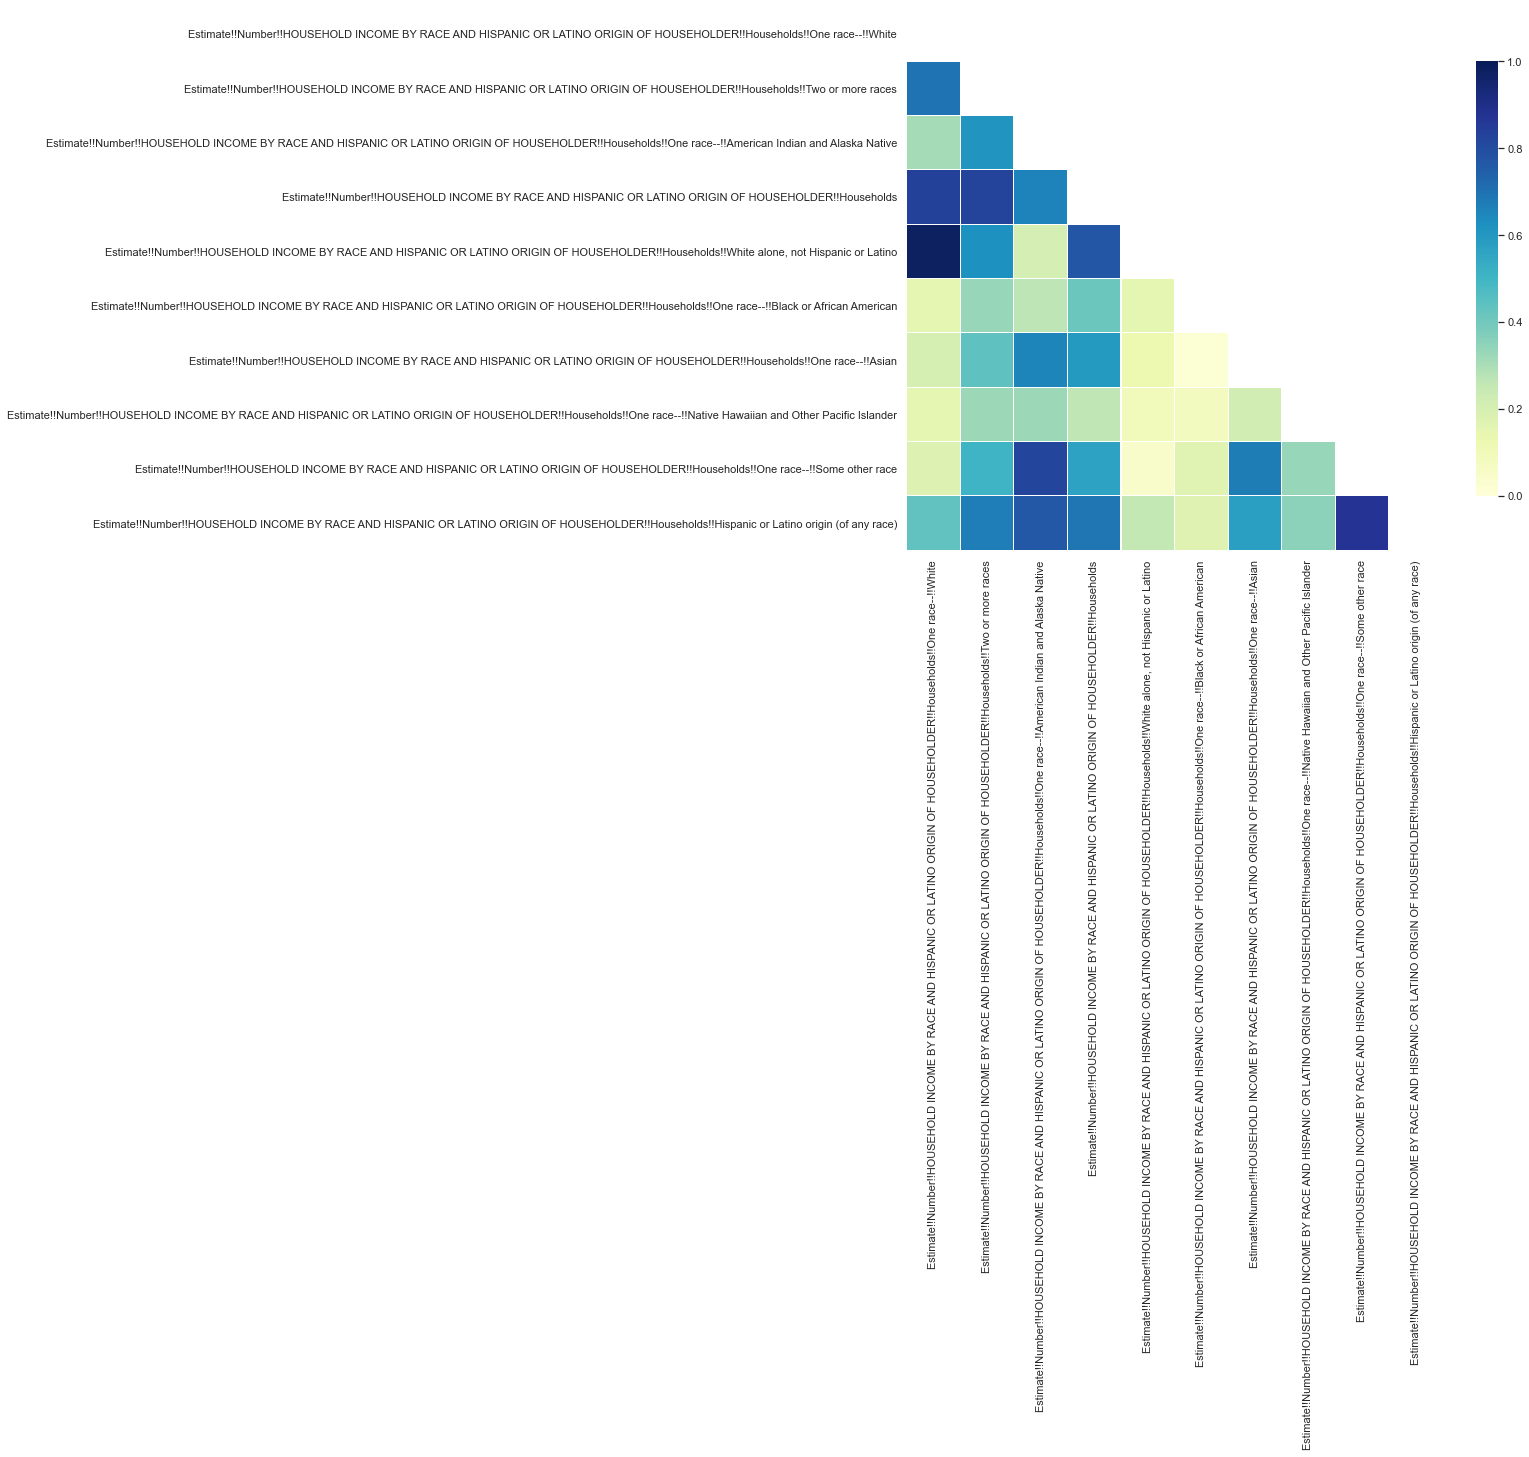

In [37]:
# Compute the correlation matrix
corr = np.abs(data[var_income_by_race].drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [38]:
aux = pd.DataFrame()
for variable in (var_income_by_race):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Two or more races
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!Asian
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Hispanic or Latino origin (of any race)
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!American Indian and Alaska Native
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!Some other race
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!White
Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!White alone, not Hispanic

abs_correlation_with_revenue  correlation_with_revenue  \
1                       0.567012                 -0.567012   
2                       0.559227                 -0.559227   
3                       0.455947                 -0.455947   
4                       0.437197                 -0.437197   
5                       0.433734                 -0.433734   
6                       0.385617                 -0.385617   
7                       0.363787                 -0.363787   
8                       0.311216                 -0.311216   
9                       0.275690                 -0.275690   
10                      0.175785                 -0.175785   

                                             variable  
1   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
2   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
3   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
4   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
5   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
6   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
7   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
8   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
9   Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...  
10  Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...

Otra vez, como con todos los sets de variables relacionados con la raza, no queremos datos tan específicos sino más generales y además que expliquen bien el revenue. 

Por lo que mantenemos:
- Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households

In [39]:
main_columns.append('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households')

### Analizamos las variables en "var_family_income"

In [40]:
var_family_income.update(['revenue'])
print('Las variables en **var_family_income** son: ')
data[var_family_income].columns.to_list()

Las variables en **var_family_income** son: 


['Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!3 or more earners',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!4-person families',
 'Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!2 earners',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!3-person families',
 'Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!No earners',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!6-person families',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!5-person families',
 'revenue',
 'Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!1 earner',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!7-or-more person families',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!2-person families']

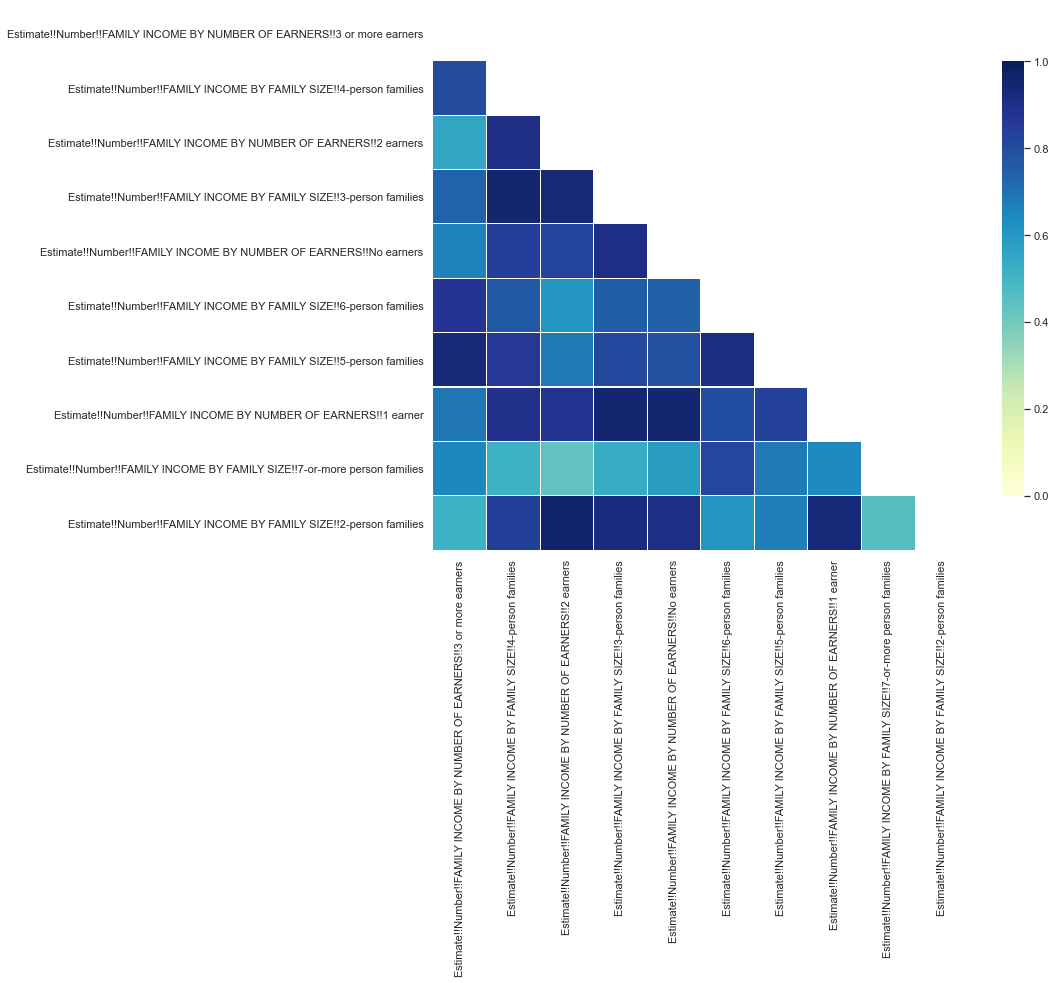

In [41]:
# Compute the correlation matrix
corr = np.abs(data[var_family_income].drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [42]:
aux = pd.DataFrame()
for variable in (var_family_income):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!2-person families
Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!1 earner
Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!3-person families
Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!No earners
Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!2 earners
Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!4-person families
Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!6-person families
Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!5-person families
Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!7-or-more person families
Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!3 or more earners


abs_correlation_with_revenue  correlation_with_revenue  \
1                       0.539111                 -0.539111   
2                       0.515540                 -0.515540   
3                       0.474814                 -0.474814   
4                       0.473281                 -0.473281   
5                       0.455457                 -0.455457   
6                       0.340745                 -0.340745   
7                       0.272832                 -0.272832   
8                       0.257459                 -0.257459   
9                       0.208793                 -0.208793   
10                      0.166610                 -0.166610   

                                             variable  
1   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
2   Estimate!!Number!!FAMILY INCOME BY NUMBER OF E...  
3   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
4   Estimate!!Number!!FAMILY INCOME BY NUMBER OF E...  
5   Estimate!!Number!!FAMILY INCOME BY NUMBER OF E...  
6   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
7   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
8   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
9   Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE...  
10  Estimate!!Number!!FAMILY INCOME BY NUMBER OF E...

Mantenemos:
- Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!2-person families
- Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!1 earner

In [43]:
main_columns.append('Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!2-person families')
main_columns.append('Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!1 earner')

### Analizamos las variables en "var_sex_age_population"

In [44]:
var_sex_age_population = {  'Estimate!!SEX AND AGE!!Total population!!5 to 9 years',
                            'Estimate!!SEX AND AGE!!Total population!!10 to 14 years',
                            'Estimate!!SEX AND AGE!!Total population!!15 to 19 years',
                            'Estimate!!SEX AND AGE!!Total population!!20 to 24 years',
                            'Estimate!!SEX AND AGE!!Total population!!25 to 34 years',
                            'Estimate!!SEX AND AGE!!Total population!!35 to 44 years',
                            'Estimate!!SEX AND AGE!!Total population!!45 to 54 years',
                            'Estimate!!SEX AND AGE!!Total population!!55 to 59 years',
                            'Estimate!!SEX AND AGE!!Total population!!60 to 64 years',
                            'Estimate!!SEX AND AGE!!Total population!!65 to 74 years',
                            'Estimate!!SEX AND AGE!!Total population!!75 to 84 years',
                            'Estimate!!SEX AND AGE!!Total population!!85 years and over'}

In [45]:
var_sex_age_population.update(['revenue'])

Comprobamos los tipos ya que en el primer análisis había algunas variables tipo "object" y ahora hemos filtrado por las que parecen más interesantes.

In [46]:
variables_types = []
for variable in var_sex_age_population:
    variable_type = data[variable].dtype
    if variable_type not in variables_types:
        variables_types.append(variable_type)
print(variables_types)

[dtype('int64'), dtype('float64')]


Todas son numéricas. Seguimos con el análisis de las correlaciones.

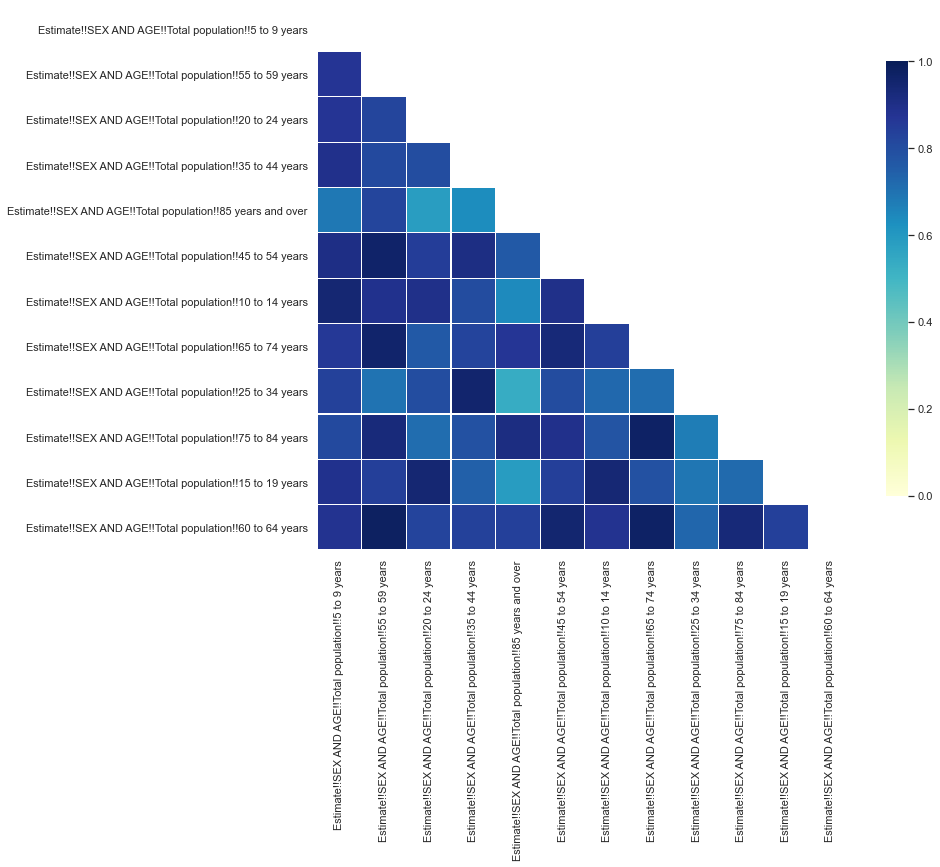

In [47]:
# Compute the correlation matrix
corr = np.abs(data[var_sex_age_population].drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [48]:
aux = pd.DataFrame()
for variable in (var_sex_age_population):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!SEX AND AGE!!Total population!!25 to 34 years
Estimate!!SEX AND AGE!!Total population!!35 to 44 years
Estimate!!SEX AND AGE!!Total population!!65 to 74 years
Estimate!!SEX AND AGE!!Total population!!75 to 84 years
Estimate!!SEX AND AGE!!Total population!!85 years and over
Estimate!!SEX AND AGE!!Total population!!60 to 64 years
Estimate!!SEX AND AGE!!Total population!!45 to 54 years
Estimate!!SEX AND AGE!!Total population!!55 to 59 years
Estimate!!SEX AND AGE!!Total population!!5 to 9 years
Estimate!!SEX AND AGE!!Total population!!20 to 24 years
Estimate!!SEX AND AGE!!Total population!!10 to 14 years
Estimate!!SEX AND AGE!!Total population!!15 to 19 years


abs_correlation_with_revenue  correlation_with_revenue  \
1                       0.538147                 -0.538147   
2                       0.515187                 -0.515187   
3                       0.468836                 -0.468836   
4                       0.465966                 -0.465966   
5                       0.456268                 -0.456268   
6                       0.439877                 -0.439877   
7                       0.418364                 -0.418364   
8                       0.411954                 -0.411954   
9                       0.411109                 -0.411109   
10                      0.366121                 -0.366121   
11                      0.298014                 -0.298014   
12                      0.283756                 -0.283756   

                                             variable  
1   Estimate!!SEX AND AGE!!Total population!!25 to...  
2   Estimate!!SEX AND AGE!!Total population!!35 to...  
3   Estimate!!SEX AND AGE!!Total population!!65 to...  
4   Estimate!!SEX AND AGE!!Total population!!75 to...  
5   Estimate!!SEX AND AGE!!Total population!!85 ye...  
6   Estimate!!SEX AND AGE!!Total population!!60 to...  
7   Estimate!!SEX AND AGE!!Total population!!45 to...  
8   Estimate!!SEX AND AGE!!Total population!!55 to...  
9   Estimate!!SEX AND AGE!!Total population!!5 to ...  
10  Estimate!!SEX AND AGE!!Total population!!20 to...  
11  Estimate!!SEX AND AGE!!Total population!!10 to...  
12  Estimate!!SEX AND AGE!!Total population!!15 to...

Mantenemos:
- Estimate!!SEX AND AGE!!Total population!!25 to 34 years
- Estimate!!SEX AND AGE!!Total population!!35 to 44 years 

In [49]:
main_columns.append('Estimate!!SEX AND AGE!!Total population!!25 to 34 years')
main_columns.append('Estimate!!SEX AND AGE!!Total population!!35 to 44 years')

Tal y como esperabamos en un inicio, las variables que más afectan al revenue del Starbucks son las relacionadas con gente joven y ya autosuficiente (ya que es un sitio caro)

### Analizamos las variables en "var_household_income_by_age"

In [50]:
var_household_income_by_age.update(['revenue'])
data[var_household_income_by_age].columns.to_list()

['Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!65 years and over',
 'Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!45 to 64 years',
 'revenue',
 'Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!25 to 44 years',
 'Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!15 to 24 years']

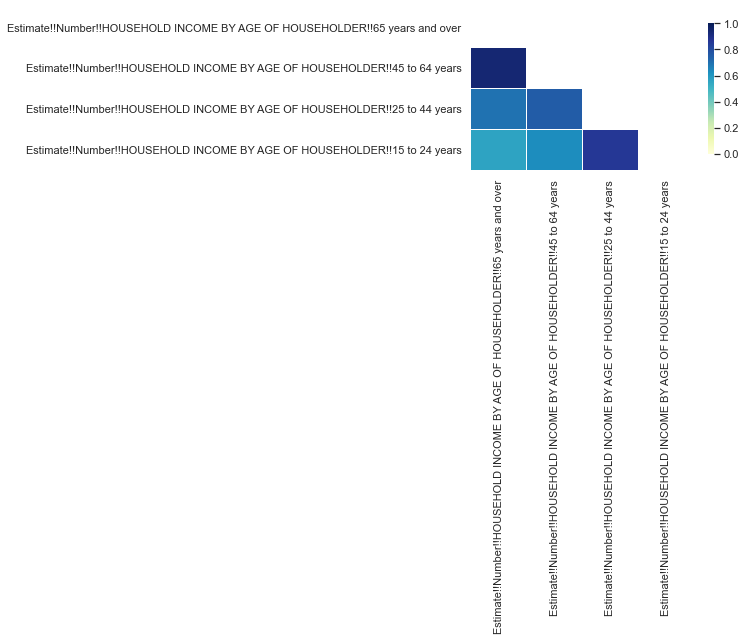

In [51]:
# Compute the correlation matrix
corr = np.abs(data[var_household_income_by_age].drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [52]:
aux = pd.DataFrame()
for variable in (var_household_income_by_age):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!25 to 44 years
Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!15 to 24 years
Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!65 years and over
Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!45 to 64 years


abs_correlation_with_revenue  correlation_with_revenue  \
1                      0.550467                 -0.550467   
2                      0.511679                 -0.511679   
3                      0.504476                 -0.504476   
4                      0.476980                 -0.476980   

                                            variable  
1  Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF H...  
2  Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF H...  
3  Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF H...  
4  Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF H...

Mantemos:
- Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!25 to 44 years
- Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!15 to 24 years

In [53]:
main_columns.append('Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!25 to 44 years')
main_columns.append('Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!15 to 24 years')

### Analizamos las variables en "var_total_housing_units"

In [54]:
var_total_housing_units.update(['revenue'])
data[var_total_housing_units].columns.to_list()

['Estimate!!Total housing units', 'revenue']

In [55]:
aux = pd.DataFrame()
for variable in (var_total_housing_units):
    aux = aux.append({'variable': variable,
                      'correlation_with_revenue': (data[variable].corr(data['revenue'])),
                      'abs_correlation_with_revenue': np.abs(data[variable].corr(data.revenue))},ignore_index = True)
aux.sort_values(by = 'abs_correlation_with_revenue',ascending  = False, inplace = True,axis = 0)
aux.reset_index(drop = True, inplace = True)

for i in range(1,aux.shape[0]):
    print(aux.loc[i, 'variable'])
aux[1:]

Estimate!!Total housing units


abs_correlation_with_revenue  correlation_with_revenue  \
1                      0.563904                 -0.563904   

                        variable  
1  Estimate!!Total housing units

In [56]:
main_columns.append('Estimate!!Total housing units')

### Nos quedamos con las columnas seleccionadas:

In [57]:
main_columns

['revenue',
 'storenumber',
 'Geographic Area Name',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Male householder!!Living alone',
 'Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!Female householder!!Living alone',
 'Estimate!!Number!!FAMILIES!!Families',
 'Estimate!!HISPANIC OR LATINO AND RACE!!Total population',
 'Estimate!!RACE!!Total population!!One race!!Asian',
 'Estimate!!RACE!!Total population!!Two or more races',
 'Estimate!!RACE!!Total population!!One race',
 'Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households',
 'Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!2-person families',
 'Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!1 earner',
 'Estimate!!SEX AND AGE!!Total population!!25 to 34 years',
 'Estimate!!SEX AND AGE!!Total population!!35 to 44 years',
 'Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!25 to 44 years',
 'Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOL

In [58]:
data = data[main_columns]

In [59]:
#Rename columns:
new_columns = {}
for column in list(data.columns):
    new_c = str(column).replace('Estimate!!SEX AND AGE!!Total population!!','Population age:').replace('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!','Householder by origin:')
    new_c = new_c.replace('Estimate!!Number!!FAMILY INCOME BY FAMILY SIZE!!','Family size').replace('Estimate!!Number!!HOUSEHOLD INCOME BY AGE OF HOUSEHOLDER!!','Householder by age:')
    new_c = new_c.replace('Estimate!!Number!!FAMILY INCOME BY NUMBER OF EARNERS!!','Number of earners:').replace('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Hispanic or Latino origin (of any race)','Householder by origin: any race')
    new_c = new_c.replace('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!White alone, not Hispanic or Latino','Householder by origin: white people')
    new_c = new_c.replace('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households','Total householders')
    new_c = new_c.replace('Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Two or more races','Householders by origin: two or more races')
    new_c = new_c.replace('Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!','Total population by race:')
    new_c = new_c.replace('Estimate!!Number!!NONFAMILY HOUSEHOLDS!!Nonfamily households!!','Nonfamiliy households:').replace('Estimate!!Number!!FAMILIES!!Families!!','Families type:')
    new_c = new_c.replace('Estimate!!CITIZIEN, VOTING AGE POPULATION!!Citizien','Voting by age:').replace('Estimate!!HISPANIC OR LATINO AND RACE!!Total population','Total hispanic or latino population')
    new_c = new_c.replace('Estimate!!Number!!FAMILIES!!Families','Number of families').replace('Estimate!!RACE!!Total population!!One race!!Asian','Total asian population')
    new_columns[column] = new_c

In [60]:
# Change the columns name to make easier read the data:
data.rename(columns=new_columns,inplace=True)

In [61]:
data.columns

Index(['revenue', 'storenumber', 'Geographic Area Name',
       'Nonfamiliy households:Male householder!!Living alone',
       'Nonfamiliy households:Female householder!!Living alone',
       'Number of families', 'Total hispanic or latino population',
       'Total asian population',
       'Estimate!!RACE!!Total population!!Two or more races',
       'Estimate!!RACE!!Total population!!One race', 'Total householders',
       'Family size2-person families', 'Number of earners:1 earner',
       'Population age:25 to 34 years', 'Population age:35 to 44 years',
       'Householder by age:25 to 44 years',
       'Householder by age:15 to 24 years', 'Estimate!!Total housing units'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


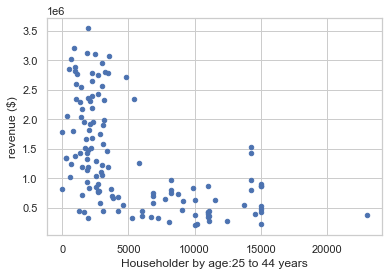

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


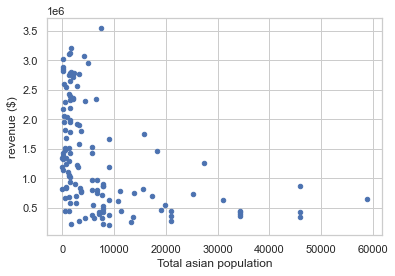

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


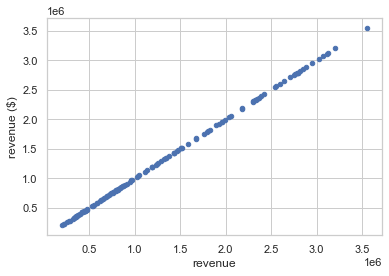

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


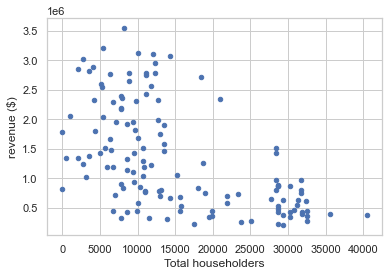

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


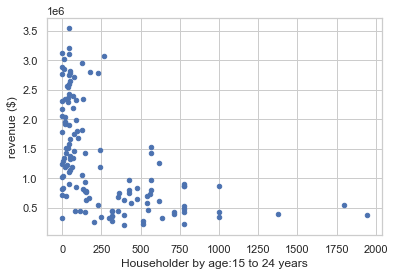

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


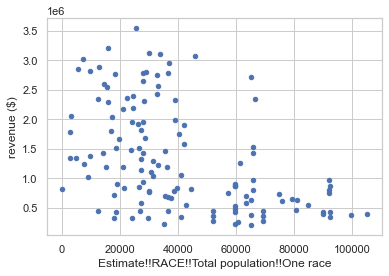

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


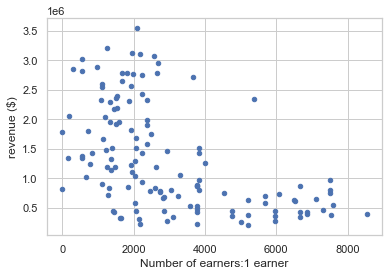

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


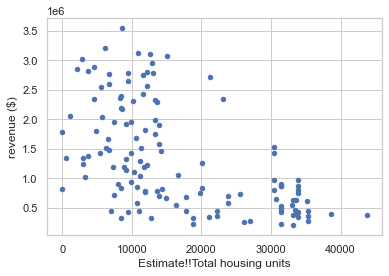

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


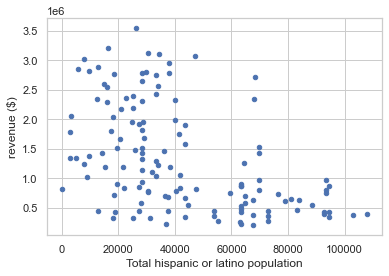

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


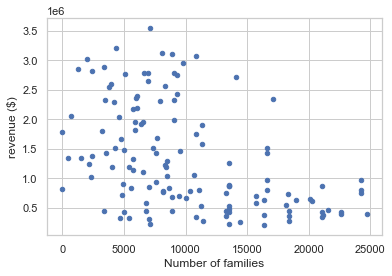

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


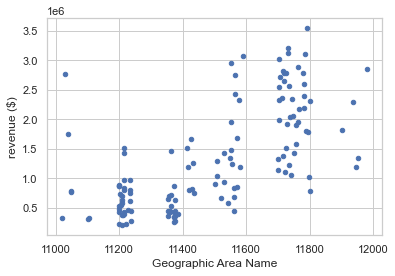

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


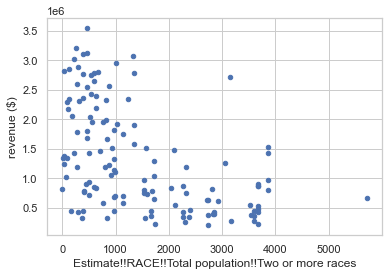

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


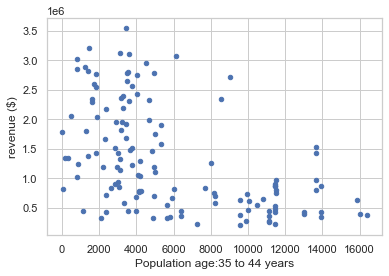

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


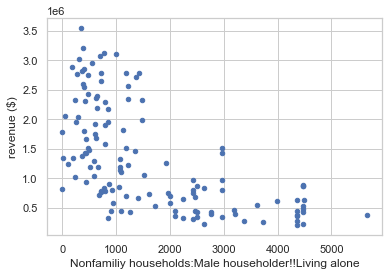

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


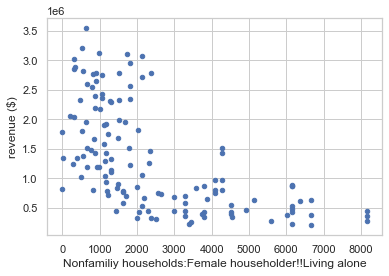

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


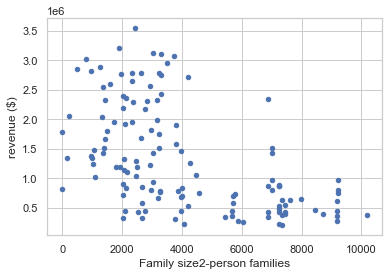

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


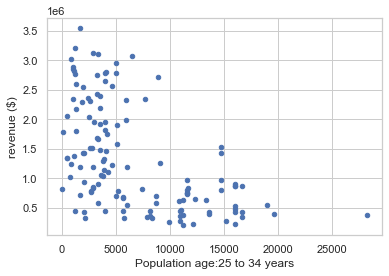

In [62]:
# Chequeo de nuevo los outliers y analizo el valor de revenue en función de ls distintas variables:

for column in set(data.columns) - set(['storenumber']):
    data.plot(kind = 'scatter',x=f'{column}',y = 'revenue')
    plt.xlabel(column)
    plt.ylabel('revenue ($)')
    plt.show()


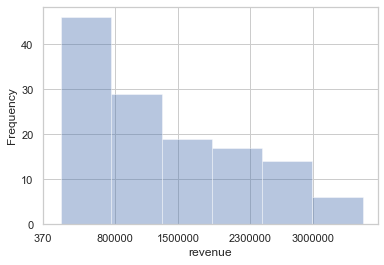

In [63]:
# Histograma de la variable revenues:
# Como podemos oberservar, la mayoría están por debajo del umbral de 800.000
values = [800000, 1500000,2300000, 3000000, 370]
data['revenue'].plot.hist(alpha=0.4, bins=6, grid = True)
plt.xlabel('revenue')
plt.xticks(values)
plt.show()

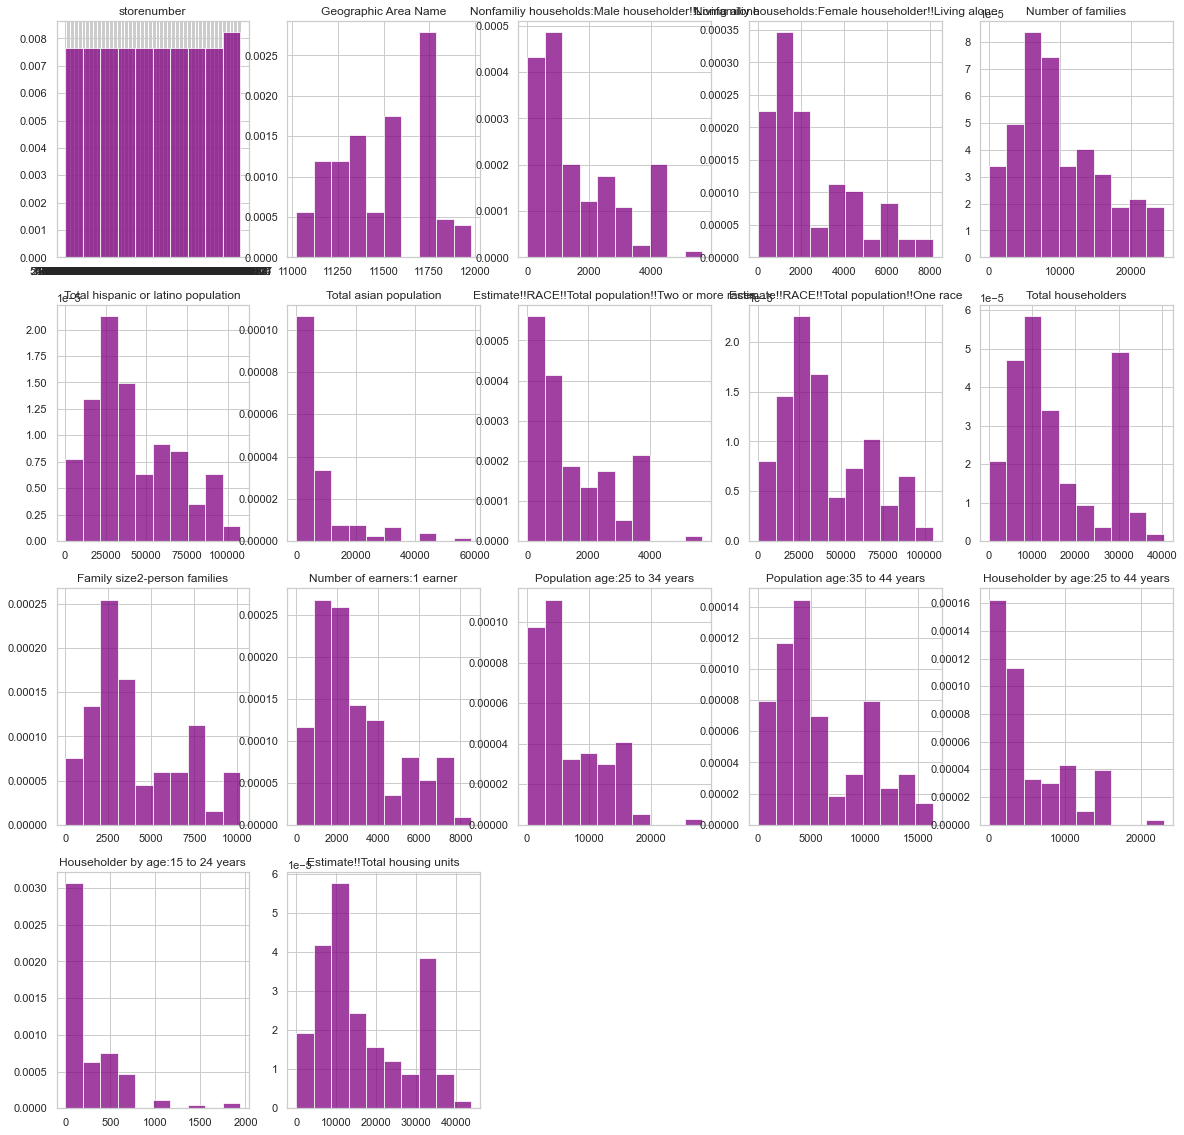

In [64]:
plt.figure(figsize=(20,20))
for i,feature in enumerate(data.columns.drop(['revenue'])):
    plt.subplot(4, 5, i+1)   
    plt.hist(data[feature], density=1, facecolor='purple', alpha=0.75)
    plt.title(feature)

plt.show()

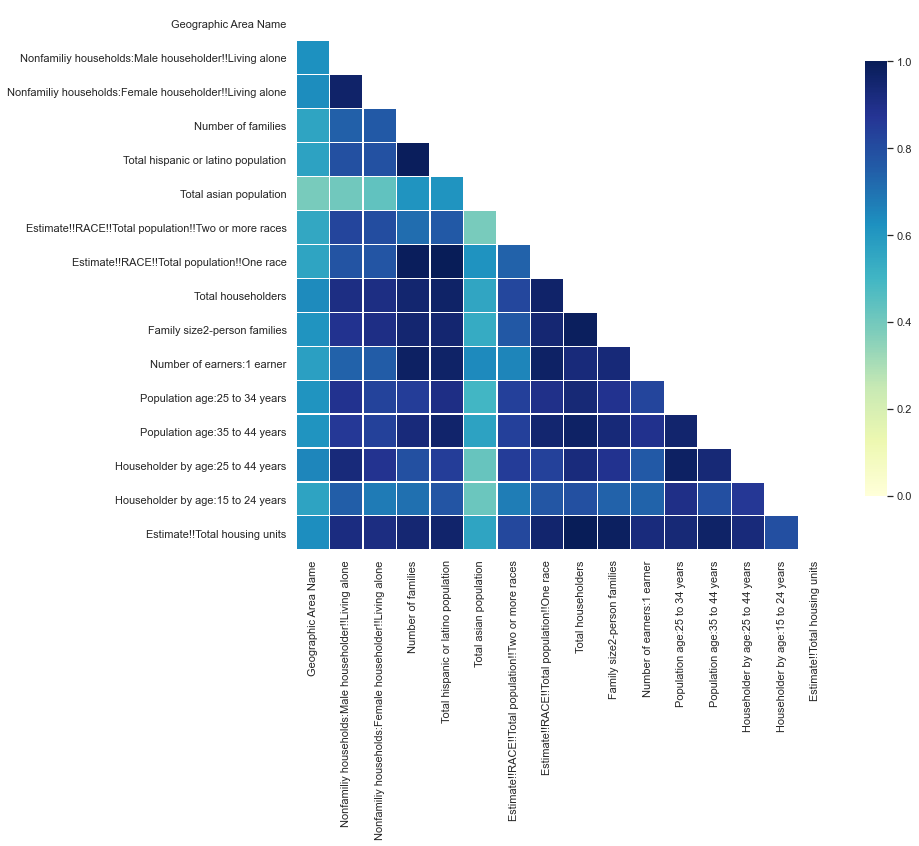

In [65]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['revenue'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# puedo representar solo la parte inferior ya que es simétrica

### Varios Starbucks en un misma zona:

In [78]:
# Hacemos la media de lso reveniu de los starbucks que pertenecen a la misma zona:
data_groupBy = data.groupby(by='Geographic Area Name', as_index=False).mean()

In [80]:
data_groupBy = data_groupBy[['revenue','Geographic Area Name']]

In [82]:
# Hacemos el merge con el dataframe original para incluir los nuevos revenue:
data = data.drop(['revenue'], axis=1)
data = data.merge(data_groupBy, left_on='Geographic Area Name', right_on='Geographic Area Name')

In [83]:
# Ordenamos las columnas para poner revenue en primer lugar
columns = list(data.columns)
columns = columns[:-1]
columns.insert(0,'revenue')
data = data[columns]

In [89]:
data = data.drop_duplicates(subset=["Geographic Area Name"])

In [91]:
data.head()

revenue   storenumber  Geographic Area Name  \
0   8.369917e+05  54804-288519                 11234   
3   6.400214e+05  76878-100172                 11210   
5   1.179643e+06     7441-1994                 11215   
9   4.466408e+05  15847-160724                 11239   
10  5.865316e+05      832-2026                 11542   

    Nonfamiliy households:Male householder!!Living alone  \
0                                                2424      
3                                                1993      
5                                                2961      
9                                                 908      
10                                                949      

    Nonfamiliy households:Female householder!!Living alone  \
0                                                4099        
3                                                3284        
5                                                4277        
9                                                2308        
10                                               1625        

    Number of families  Total hispanic or latino population  \
0                24247                                93534   
3                15677                                64665   
5                16621                                69873   
9                 3360                                12772   
10                6808                                27893   

    Total asian population  \
0                     6783   
3                     2625   
5                     5680   
9                      488   
10                    1430   

    Estimate!!RACE!!Total population!!Two or more races  \
0                                                1533     
3                                                1137     
5                                                3868     
9                                                 156     
10                                                758     

    Estimate!!RACE!!Total population!!One race  Total householders  \
0                                        92001               31743   
3                                        63528               21893   
5                                        66005               28445   
9                                        12616                6705   
10                                       27135                9998   

    Family size2-person families  Number of earners:1 earner  \
0                           9203                        7509   
3                           5719                        5678   
5                           7008                        3826   
9                           2098                        1415   
10                          2650                        2025   

    Population age:25 to 34 years  Population age:35 to 44 years  \
0                           11577                          11523   
3                            8666                           8252   
5                           14717                          13637   
9                            1165                           1122   
10                           3329                           3359   

    Householder by age:25 to 44 years  Householder by age:15 to 24 years  \
0                                8203                                423   
3                                6853                                542   
5                               14256                                565   
9                                1238                                115   
10                               2856                                437   

    Estimate!!Total housing units  
0                           33959  
3                           23801  
5                           30479  
9                            6983  
10                          10689

In [92]:
# Guardamos en formato .csv el nuevo dataframe procesado:
data.to_csv('../Datasets/SocialDemographicAnalyze.csv', index=False)